### Import Packages

In [21]:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn

from utils.preprocess import getData
from utils.validate import validate
from networks.cnn import BasicCNN
from networks.cnn import OptimizedCNN
from networks.cnn import OptimizedCNNV2
from networks.cnn import DeepCNN
from networks.cnn import VariableFiltersCNN
import matplotlib.pyplot as plt
from utils.test_accuracy import test
from utils.test_accuracy import compute_test_outputs
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load, Preprocess Data


In [30]:
X_train, y_train, X_valid, y_valid, X_test, y_test, mapToOriginal = getData(lib='torch')

### Shape of data

In [31]:
print('Training data shape: {}'.format(X_train.shape))
print('Valid data shape: {}'.format(X_valid.shape))
print('Test data shape: {}'.format(X_test.shape))

print('Training target shape: {}'.format(y_train.shape))
print('Valid target shape: {}'.format(y_valid.shape))
print('Test target shape: {}'.format(y_test.shape))

Training data shape: torch.Size([1728, 22, 250, 1])
Valid data shape: torch.Size([423, 22, 250, 1])
Test data shape: torch.Size([1772, 22, 250, 1])
Training target shape: torch.Size([1728, 4])
Valid target shape: torch.Size([423, 4])
Test target shape: torch.Size([1772, 4])


### Initialize Dataset and DataLoaders

In [4]:
batch_size=64
trainset = torch.utils.data.TensorDataset(X_train,y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

# Shuffle is set to false for validation and test sets since no training is done on them, all we do is evaluate.
valset =  torch.utils.data.TensorDataset(X_valid, y_valid)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

testset = torch.utils.data.TensorDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=0)

### Train a Convolutional Neural Network

In [14]:
# Initialize the network
network = BasicCNN()
print(network)

BasicCNN(
  (conv1): Conv2d(22, 25, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(50, 100, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (conv4): Conv2d(100, 200, kernel_size=(10, 1), str

In [11]:
# Select loss criterion
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

# Setup learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Train the network
num_epochs = 20

# Store the loss
stats = {
    'train_accuracies': [],
    'train_losses': [],
    'val_accuracies': [],
    'val_losses': []
}

for epoch in range(num_epochs): # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
  
        # forward pass
        outputs = network(inputs)
        
        loss = criterion(outputs, labels)
        

        # backward + optimize
        loss.backward() # backward to get gradient values
        
        optimizer.step() # does the update
    
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # accumulate loss
        running_loss += loss.item()
        
        # Make prediction for batch
        _, predicted = outputs.max(1)
        
        # Store accuracy for batch
        # WE convert back from one-hot to integer for checking accuracy
        total += labels.size(0)
        correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
    # Store accuracy,loss for epoch
    train_loss=running_loss/len(trainloader)
    train_accuracy=100.*correct/total
    
    # At the end of each epoch, calculate validation accuracy
    
    # Set the network in eval mode since we're not training here
    network.eval()
    
     # Turn gradient computation off
    with torch.no_grad():
        val_accuracy, val_loss = validate(network, valloader, criterion)
    
    # Set the network back in training mode
    network.train()
    
    stats['train_accuracies'].append(train_accuracy)
    stats['train_losses'].append(train_loss)
    stats['val_accuracies'].append(val_accuracy)
    stats['val_losses'].append(val_loss)
    
    
    # Display results
    print(f'Epoch: {epoch}')
    print(f'\t -- Train Loss: {train_loss} | Train Accuracy: {train_accuracy}')
    print(f'\t -- Val Loss: {val_loss} | Val Accuracy: {val_accuracy}')
    
    # At the end of each epoch, schedule the learning rate decay
    scheduler.step()

/Users/siddharthladha/opt/anaconda3/envs/finalProject/lib/python3.9/site-packages/torch/nn/modules/conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 0
	 -- Train Loss: 3.2646478523901843 | Train Accuracy: 42.47126436781609
	 -- Val Loss: 2.778337443868319 | Val Accuracy: 47.4
Epoch: 1
	 -- Train Loss: 2.6728703833501273 | Train Accuracy: 56.867816091954026
	 -- Val Loss: 1.7206367899974186 | Val Accuracy: 62.6
Epoch: 2
	 -- Train Loss: 1.8336009678490666 | Train Accuracy: 67.05459770114942
	 -- Val Loss: 1.5905541256070137 | Val Accuracy: 66.0
Epoch: 3
	 -- Train Loss: 1.3209000076722661 | Train Accuracy: 73.72126436781609
	 -- Val Loss: 1.4152166247367859 | Val Accuracy: 69.66666666666667
Epoch: 4
	 -- Train Loss: 0.9155816865076712 | Train Accuracy: 80.17241379310344
	 -- Val Loss: 0.9820176747937998 | Val Accuracy: 78.0
Epoch: 5
	 -- Train Loss: 0.6672043010182337 | Train Accuracy: 83.47701149425288
	 -- Val Loss: 0.7940009571611881 | Val Accuracy: 79.73333333333333
Epoch: 6
	 -- Train Loss: 0.5427009351209763 | Train Accuracy: 86.6235632183908
	 -- Val Loss: 0.3672515243912737 | Val Accuracy: 88.8
Epoch: 7
	 -- Train Los

### Plot training curves

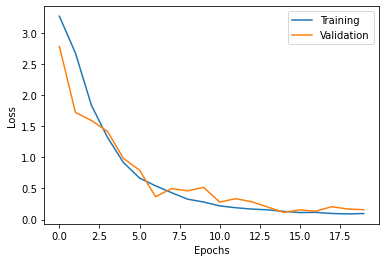

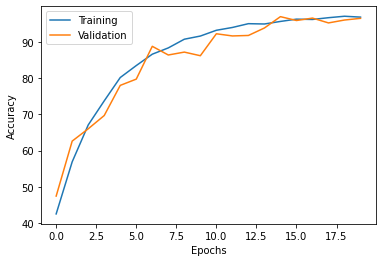

In [12]:
plt.figure()
plt.plot(np.arange(num_epochs), stats['train_losses'], label='Training')
plt.plot(np.arange(num_epochs), stats['val_losses'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(num_epochs), stats['train_accuracies'], label='Training')
plt.plot(np.arange(num_epochs), stats['val_accuracies'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluate on Test Set

In [13]:
# Set the network in eval mode since we're not training here

network.eval()
outputs = None

 # Turn gradient computation off
with torch.no_grad():
    outputs = compute_test_outputs(network,testloader,y_test)
    
# Set the network back in training mode
network.train()
    
    
test_accuracy = test(outputs, mapToOriginal['y_test'])

num_examples = mapToOriginal['y_test'].size


print(f'Accuracy of the network on the {num_examples} test examples: {test_accuracy} %')

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


Accuracy of the network on the 443 test examples: 57.78781038374717 %


### Save the model for inference or further training

In [14]:
path = "saved-models/basicCNN2.pth"
state = {
    'epoch': 5,
    'state_dict': network.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, path)

### Optimizing the model

Now, let us try to optimize the model by varying the configuration of the layers, and using hyperparameter tuning to determine the best filter size, among other hyper paramaters

From lectures, we have learnt that it is often useful to have multiple convolutional layers before a pooling layer to add complexity to our model.

In addition, it is also advisable to put the batch-normalization layer immediately after the convolutional layer. (from lecture).

Let us try these ideas below:

In [15]:
# Initialize the network
network = OptimizedCNN()
print(network)

OptimizedCNN(
  (conv1): Conv2d(22, 25, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (batchnorm1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (pool1): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 100, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (batchnorm3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (conv4): Conv2d(100, 200, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (batchnorm4): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.4, inplace=False)
  (pool2): MaxPool2d(

In [16]:
# Select loss criterion
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

# Setup learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Train the network
num_epochs = 10

# Store the loss
stats = {
    'train_accuracies': [],
    'train_losses': [],
    'val_accuracies': [],
    'val_losses': []
}

for epoch in range(num_epochs): # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
  
        # forward pass
        outputs = network(inputs)
        
        loss = criterion(outputs, labels)
        

        # backward + optimize
        loss.backward() # backward to get gradient values
        
        optimizer.step() # does the update
    
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # accumulate loss
        running_loss += loss.item()
        
        # Make prediction for batch
        _, predicted = outputs.max(1)
        
        # Store accuracy for batch
        # WE convert back from one-hot to integer for checking accuracy
        total += labels.size(0)
        correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
    # Store accuracy,loss for epoch
    train_loss=running_loss/len(trainloader)
    train_accuracy=100.*correct/total
    
    # At the end of each epoch, calculate validation accuracy
    
    # Set the network in eval mode since we're not training here
    network.eval()
    
     # Turn gradient computation off
    with torch.no_grad():
        val_accuracy, val_loss = validate(network, valloader, criterion)
    
    # Set the network back in training mode
    network.train()
    
    stats['train_accuracies'].append(train_accuracy)
    stats['train_losses'].append(train_loss)
    stats['val_accuracies'].append(val_accuracy)
    stats['val_losses'].append(val_loss)
    
    
    # Display results
    print(f'Epoch: {epoch}')
    print(f'\t -- Train Loss: {train_loss} | Train Accuracy: {train_accuracy}')
    print(f'\t -- Val Loss: {val_loss} | Val Accuracy: {val_accuracy}')
    
    # At the end of each epoch, schedule the learning rate decay
    scheduler.step()

Epoch: 0
	 -- Train Loss: 7.163239629990464 | Train Accuracy: 31.882183908045977
	 -- Val Loss: 3.117256780465444 | Val Accuracy: 32.53333333333333
Epoch: 1
	 -- Train Loss: 5.40870305266949 | Train Accuracy: 39.798850574712645
	 -- Val Loss: 27.874557971954346 | Val Accuracy: 28.666666666666668
Epoch: 2
	 -- Train Loss: 4.09515522051295 | Train Accuracy: 43.9080459770115
	 -- Val Loss: 43.28024927775065 | Val Accuracy: 30.733333333333334
Epoch: 3
	 -- Train Loss: 2.933387707132812 | Train Accuracy: 47.701149425287355
	 -- Val Loss: 12341.8271484375 | Val Accuracy: 24.466666666666665


KeyboardInterrupt: 

In [12]:
network.eval()
outputs = None

 # Turn gradient computation off
with torch.no_grad():
    outputs = compute_test_outputs(network,testloader,y_test)
    
# Set the network back in training mode
network.train()
    
    
test_accuracy = test(outputs, mapToOriginal['y_test'])

num_examples = mapToOriginal['y_test'].size


print(f'Accuracy of the network on the {num_examples} test examples: {test_accuracy} %')

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


Accuracy of the network on the 443 test examples: 40.85778781038375 %


### Optimizing Again

However, after testing such an architecture, we find that it performs worse than the BasicCNN above.

In that case, we turn to a new idea: Using the same BasicCNN architecture, but changing varying filter sizes and numbers, along with dropout probabilities as shown below:

Since we are performing much worse on the test set than the train and validation set, we can assume that our model needs to generalize to unseen data better. Thus, we should explore a more aggressive dropout value. The above model does this:

In [33]:
# Initialize the network
network = OptimizedCNNV2(dropout=0.6)
print(network)

OptimizedCNNV2(
  (conv1): Conv2d(22, 25, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.6, inplace=False)
  (conv2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.6, inplace=False)
  (conv3): Conv2d(50, 100, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.6, inplace=False)
  (conv4): Conv2d(100, 200, kernel_size=(10, 1

In [34]:
# Select loss criterion
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

# Setup learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Train the network
num_epochs = 10

# Store the loss
stats = {
    'train_accuracies': [],
    'train_losses': [],
    'val_accuracies': [],
    'val_losses': []
}

for epoch in range(num_epochs): # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
  
        # forward pass
        outputs = network(inputs)
        
        loss = criterion(outputs, labels)
        

        # backward + optimize
        loss.backward() # backward to get gradient values
        
        optimizer.step() # does the update
    
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # accumulate loss
        running_loss += loss.item()
        
        # Make prediction for batch
        _, predicted = outputs.max(1)
        
        # Store accuracy for batch
        # WE convert back from one-hot to integer for checking accuracy
        total += labels.size(0)
        correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
    # Store accuracy,loss for epoch
    train_loss=running_loss/len(trainloader)
    train_accuracy=100.*correct/total
    
    # At the end of each epoch, calculate validation accuracy
    
    # Set the network in eval mode since we're not training here
    network.eval()
    
     # Turn gradient computation off
    with torch.no_grad():
        val_accuracy, val_loss = validate(network, valloader, criterion)
    
    # Set the network back in training mode
    network.train()
    
    stats['train_accuracies'].append(train_accuracy)
    stats['train_losses'].append(train_loss)
    stats['val_accuracies'].append(val_accuracy)
    stats['val_losses'].append(val_loss)
    
    
    # Display results
    print(f'Epoch: {epoch}')
    print(f'\t -- Train Loss: {train_loss} | Train Accuracy: {train_accuracy}')
    print(f'\t -- Val Loss: {val_loss} | Val Accuracy: {val_accuracy}')
    
    # At the end of each epoch, schedule the learning rate decay
    scheduler.step()

Epoch: 0
	 -- Train Loss: 3.3448479788019023 | Train Accuracy: 36.5948275862069
	 -- Val Loss: 3.936804632345835 | Val Accuracy: 33.266666666666666
Epoch: 1
	 -- Train Loss: 3.791455459157261 | Train Accuracy: 44.89942528735632
	 -- Val Loss: 3.4451233943303428 | Val Accuracy: 42.333333333333336
Epoch: 2
	 -- Train Loss: 3.117615513845321 | Train Accuracy: 51.910919540229884
	 -- Val Loss: 3.5258830785751343 | Val Accuracy: 48.13333333333333
Epoch: 3
	 -- Train Loss: 2.824068847052548 | Train Accuracy: 55.40229885057471
	 -- Val Loss: 2.5542559574047723 | Val Accuracy: 52.6
Epoch: 4
	 -- Train Loss: 2.255259522604286 | Train Accuracy: 61.30747126436781
	 -- Val Loss: 1.7741254170735676 | Val Accuracy: 60.4
Epoch: 5
	 -- Train Loss: 2.0331569735063324 | Train Accuracy: 62.98850574712644
	 -- Val Loss: 2.6911876996358237 | Val Accuracy: 52.86666666666667
Epoch: 6
	 -- Train Loss: 1.8464201918435752 | Train Accuracy: 66.02011494252874
	 -- Val Loss: 1.7625255386034648 | Val Accuracy: 56.5

In [32]:
network.eval()
outputs = None

 # Turn gradient computation off
with torch.no_grad():
    outputs = compute_test_outputs(network,testloader,y_test)
    
# Set the network back in training mode
network.train()
    
    
test_accuracy = test(outputs, mapToOriginal['y_test'])

num_examples = mapToOriginal['y_test'].size


print(f'Accuracy of the network on the {num_examples} test examples: {test_accuracy} %')

Accuracy of the network on the 443 test examples: 25.056433408577877 %


Clearly, the aggressive dropout value does not seem to work. Let us now try changing the convolutional filter size

In [36]:
network = OptimizedCNNV2(dropout=0.4, filter_size = (20,1))
print(network)

OptimizedCNNV2(
  (conv1): Conv2d(22, 25, kernel_size=(20, 1), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(25, 50, kernel_size=(20, 1), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(50, 100, kernel_size=(20, 1), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (conv4): Conv2d(100, 200, kernel_size=(20, 1

In [37]:
# Select loss criterion
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

# Setup learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Train the network
num_epochs = 10

# Store the loss
stats = {
    'train_accuracies': [],
    'train_losses': [],
    'val_accuracies': [],
    'val_losses': []
}

for epoch in range(num_epochs): # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
  
        # forward pass
        outputs = network(inputs)
        
        loss = criterion(outputs, labels)
        

        # backward + optimize
        loss.backward() # backward to get gradient values
        
        optimizer.step() # does the update
    
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # accumulate loss
        running_loss += loss.item()
        
        # Make prediction for batch
        _, predicted = outputs.max(1)
        
        # Store accuracy for batch
        # WE convert back from one-hot to integer for checking accuracy
        total += labels.size(0)
        correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
    # Store accuracy,loss for epoch
    train_loss=running_loss/len(trainloader)
    train_accuracy=100.*correct/total
    
    # At the end of each epoch, calculate validation accuracy
    
    # Set the network in eval mode since we're not training here
    network.eval()
    
     # Turn gradient computation off
    with torch.no_grad():
        val_accuracy, val_loss = validate(network, valloader, criterion)
    
    # Set the network back in training mode
    network.train()
    
    stats['train_accuracies'].append(train_accuracy)
    stats['train_losses'].append(train_loss)
    stats['val_accuracies'].append(val_accuracy)
    stats['val_losses'].append(val_loss)
    
    
    # Display results
    print(f'Epoch: {epoch}')
    print(f'\t -- Train Loss: {train_loss} | Train Accuracy: {train_accuracy}')
    print(f'\t -- Val Loss: {val_loss} | Val Accuracy: {val_accuracy}')
    
    # At the end of each epoch, schedule the learning rate decay
    scheduler.step()

Epoch: 0
	 -- Train Loss: 3.7248429409954524 | Train Accuracy: 37.42816091954023
	 -- Val Loss: 3.0248947739601135 | Val Accuracy: 40.666666666666664
Epoch: 1
	 -- Train Loss: 2.826133613192707 | Train Accuracy: 50.67528735632184
	 -- Val Loss: 2.754539499680201 | Val Accuracy: 49.4
Epoch: 2
	 -- Train Loss: 2.000901311909387 | Train Accuracy: 60.79022988505747
	 -- Val Loss: 1.693855106830597 | Val Accuracy: 62.46666666666667
Epoch: 3
	 -- Train Loss: 1.3590182645605244 | Train Accuracy: 69.55459770114942
	 -- Val Loss: 1.1361853207151096 | Val Accuracy: 70.73333333333333
Epoch: 4
	 -- Train Loss: 1.0640239805803386 | Train Accuracy: 75.47413793103448
	 -- Val Loss: 1.1719834382335346 | Val Accuracy: 70.53333333333333
Epoch: 5
	 -- Train Loss: 0.7456813836043034 | Train Accuracy: 81.02011494252874
	 -- Val Loss: 0.6136873755604029 | Val Accuracy: 82.73333333333333
Epoch: 6
	 -- Train Loss: 0.5266175070487031 | Train Accuracy: 84.94252873563218
	 -- Val Loss: 0.4612935396532218 | Val A

In [38]:
network.eval()
outputs = None

 # Turn gradient computation off
with torch.no_grad():
    outputs = compute_test_outputs(network,testloader,y_test)
    
# Set the network back in training mode
network.train()
    
    
test_accuracy = test(outputs, mapToOriginal['y_test'])

num_examples = mapToOriginal['y_test'].size


print(f'Accuracy of the network on the {num_examples} test examples: {test_accuracy} %')

Accuracy of the network on the 443 test examples: 54.176072234762984 %


This network performs about as well as our initial basic network. Let's now try decreasing the convolutional filter size, and increasing the depth of our network. (to maintain the same receptive field)

In [47]:
network = DeepCNN(dropout=0.4, filter_size = (5,1))
print(network)

DeepCNN(
  (conv1): Conv2d(22, 25, kernel_size=(5, 1), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(25, 50, kernel_size=(5, 1), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(50, 100, kernel_size=(5, 1), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (conv4): Conv2d(100, 200, kernel_size=(5, 1), stride=(

In [48]:
# Select loss criterion
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

# Setup learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Train the network
num_epochs = 10

# Store the loss
stats = {
    'train_accuracies': [],
    'train_losses': [],
    'val_accuracies': [],
    'val_losses': []
}

for epoch in range(num_epochs): # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
  
        # forward pass
        outputs = network(inputs)
        
        loss = criterion(outputs, labels)
        

        # backward + optimize
        loss.backward() # backward to get gradient values
        
        optimizer.step() # does the update
    
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # accumulate loss
        running_loss += loss.item()
        
        # Make prediction for batch
        _, predicted = outputs.max(1)
        
        # Store accuracy for batch
        # WE convert back from one-hot to integer for checking accuracy
        total += labels.size(0)
        correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
    # Store accuracy,loss for epoch
    train_loss=running_loss/len(trainloader)
    train_accuracy=100.*correct/total
    
    # At the end of each epoch, calculate validation accuracy
    
    # Set the network in eval mode since we're not training here
    network.eval()
    
     # Turn gradient computation off
    with torch.no_grad():
        val_accuracy, val_loss = validate(network, valloader, criterion)
    
    # Set the network back in training mode
    network.train()
    
    stats['train_accuracies'].append(train_accuracy)
    stats['train_losses'].append(train_loss)
    stats['val_accuracies'].append(val_accuracy)
    stats['val_losses'].append(val_loss)
    
    
    # Display results
    print(f'Epoch: {epoch}')
    print(f'\t -- Train Loss: {train_loss} | Train Accuracy: {train_accuracy}')
    print(f'\t -- Val Loss: {val_loss} | Val Accuracy: {val_accuracy}')
    
    # At the end of each epoch, schedule the learning rate decay
    scheduler.step()

Epoch: 0
	 -- Train Loss: 1.6492772058609428 | Train Accuracy: 40.60344827586207
	 -- Val Loss: 1.2389489139119785 | Val Accuracy: 47.46666666666667
Epoch: 1
	 -- Train Loss: 1.3457449723821167 | Train Accuracy: 55.201149425287355
	 -- Val Loss: 1.3005520502726238 | Val Accuracy: 49.4
Epoch: 2
	 -- Train Loss: 1.0438917328458313 | Train Accuracy: 63.160919540229884
	 -- Val Loss: 1.1931135058403015 | Val Accuracy: 52.53333333333333
Epoch: 3
	 -- Train Loss: 0.8821134583665691 | Train Accuracy: 69.066091954023
	 -- Val Loss: 0.8955751533309618 | Val Accuracy: 62.86666666666667
Epoch: 4
	 -- Train Loss: 0.699154916979851 | Train Accuracy: 74.18103448275862
	 -- Val Loss: 0.7968036358555158 | Val Accuracy: 69.53333333333333
Epoch: 5
	 -- Train Loss: 0.5880448974053795 | Train Accuracy: 77.77298850574712
	 -- Val Loss: 0.6987029674152533 | Val Accuracy: 73.2
Epoch: 6
	 -- Train Loss: 0.5064953859519521 | Train Accuracy: 81.16379310344827
	 -- Val Loss: 0.6284670444826285 | Val Accuracy: 74

In [49]:
network.eval()
outputs = None

 # Turn gradient computation off
with torch.no_grad():
    outputs = compute_test_outputs(network,testloader,y_test)
    
# Set the network back in training mode
network.train()
    
    
test_accuracy = test(outputs, mapToOriginal['y_test'])

num_examples = mapToOriginal['y_test'].size


print(f'Accuracy of the network on the {num_examples} test examples: {test_accuracy} %')

Accuracy of the network on the 443 test examples: 54.85327313769752 %


Even this deeper CNN with smaller filter size does not perform better than the original Basic CNN. At this point, we concede that the Basic CNN architecture is the most suitable out of all the ones we tested, and we vary its number of filters and learning rate in an attempt to achieve even greater performance.

In [10]:
network = VariableFiltersCNN(filters=[50,100,200,250])
print(network)

VariableFiltersCNN(
  (conv1): Conv2d(22, 50, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(50, 100, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(100, 200, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (conv4): Conv2d(200, 250, kernel_size

In [13]:
# Select loss criterion
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

# Setup learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Train the network
num_epochs = 10

# Store the loss
stats = {
    'train_accuracies': [],
    'train_losses': [],
    'val_accuracies': [],
    'val_losses': []
}

for epoch in range(num_epochs): # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
  
        # forward pass
        outputs = network(inputs)
        
        loss = criterion(outputs, labels)
        

        # backward + optimize
        loss.backward() # backward to get gradient values
        
        optimizer.step() # does the update
    
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # accumulate loss
        running_loss += loss.item()
        
        # Make prediction for batch
        _, predicted = outputs.max(1)
        
        # Store accuracy for batch
        # WE convert back from one-hot to integer for checking accuracy
        total += labels.size(0)
        correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
    # Store accuracy,loss for epoch
    train_loss=running_loss/len(trainloader)
    train_accuracy=100.*correct/total
    
    # At the end of each epoch, calculate validation accuracy
    
    # Set the network in eval mode since we're not training here
    network.eval()
    
     # Turn gradient computation off
    with torch.no_grad():
        val_accuracy, val_loss = validate(network, valloader, criterion)
    
    # Set the network back in training mode
    network.train()
    
    stats['train_accuracies'].append(train_accuracy)
    stats['train_losses'].append(train_loss)
    stats['val_accuracies'].append(val_accuracy)
    stats['val_losses'].append(val_loss)
    
    
    # Display results
    print(f'Epoch: {epoch}')
    print(f'\t -- Train Loss: {train_loss} | Train Accuracy: {train_accuracy}')
    print(f'\t -- Val Loss: {val_loss} | Val Accuracy: {val_accuracy}')
    
    # At the end of each epoch, schedule the learning rate decay
    scheduler.step()

Epoch: 0
	 -- Train Loss: 3.0755797919877077 | Train Accuracy: 56.22126436781609
	 -- Val Loss: 1.963074008623759 | Val Accuracy: 60.733333333333334
Epoch: 1
	 -- Train Loss: 2.8278079962511673 | Train Accuracy: 64.89942528735632
	 -- Val Loss: 2.5242406179507575 | Val Accuracy: 68.2
Epoch: 2
	 -- Train Loss: 1.5940576332424758 | Train Accuracy: 76.19252873563218
	 -- Val Loss: 1.1014363082746665 | Val Accuracy: 80.53333333333333
Epoch: 3
	 -- Train Loss: 0.8575210496099717 | Train Accuracy: 85.43103448275862
	 -- Val Loss: 0.6017377520911396 | Val Accuracy: 86.4
Epoch: 4
	 -- Train Loss: 0.6627640864307728 | Train Accuracy: 87.61494252873563
	 -- Val Loss: 0.7136821721990904 | Val Accuracy: 85.6
Epoch: 5
	 -- Train Loss: 0.37825643156714944 | Train Accuracy: 92.55747126436782
	 -- Val Loss: 0.454383901009957 | Val Accuracy: 90.66666666666667
Epoch: 6
	 -- Train Loss: 0.22429401890605416 | Train Accuracy: 95.01436781609195
	 -- Val Loss: 0.2379183537462571 | Val Accuracy: 93.8666666666

In [14]:
# Set the network in eval mode since we're not training here

network.eval()
outputs = None

 # Turn gradient computation off
with torch.no_grad():
    outputs = compute_test_outputs(network,testloader,y_test)
    
# Set the network back in training mode
network.train()
    
    
test_accuracy = test(outputs, mapToOriginal['y_test'])

num_examples = mapToOriginal['y_test'].size


print(f'Accuracy of the network on the {num_examples} test examples: {test_accuracy} %')

Accuracy of the network on the 443 test examples: 59.14221218961625 %


This is the best network we've seen so far. It gets an accuracy slightly better than the next best CNN so far (BasicCNN), even though it trains for half the epochs. 

If we wanted, we could get much higher accuracy on this network by training for longer, but this would require a high amount of compute resources, and potentially a GPU. The large number of filters in each layer means training a batch takes a much larger amount of time than Basic CNN.

### Plot training curves

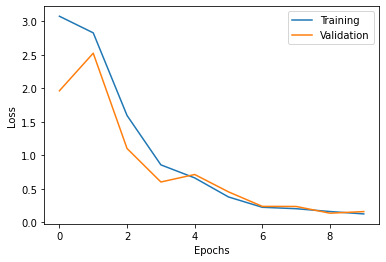

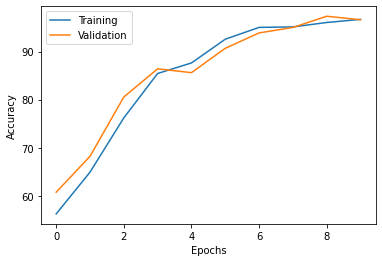

In [15]:
plt.figure()
plt.plot(np.arange(num_epochs), stats['train_losses'], label='Training')
plt.plot(np.arange(num_epochs), stats['val_losses'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(num_epochs), stats['train_accuracies'], label='Training')
plt.plot(np.arange(num_epochs), stats['val_accuracies'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Conclusion

The best network for this task is the VariableFiltersCNN with filters=[50,100,200,250]. Thus, working with the BasicCNN and incresing the number of filters is the best way to get high accuracy on this dataset. We still need to train for a large number of epochs, though.

However, there is still going to be a discrepancy between the accuracy on the train/validation and test sets. Increasing regularization through more aggressive dropout does not seem to help our network.

In addition, experimenting with different learning rates might help our model, but since we use Batch Normalization and Xavier Initializations, our model should be more resistant to changes in learning rate.

Finally, an idea to improve the test accuracy is to use more intensive preprocessing. A paper I found on preprocessing for EEG data, that was also used to preprocess data fro EEGNet, is here: 

https://www.frontiersin.org/articles/10.3389/fninf.2015.00016/full

However, the code for the PREP pipeline is written is matlab, and given the time to complete the project, it was unfeasible to convert it to python.

### Save this model

In [5]:
path = "saved-models/VariableFiltersCNN.pth"
state = {
    'epoch': 9,
    'state_dict': network.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, path)

NameError: name 'network' is not defined

# Training on Single Subject
 Now that we have trained over the entire dataset, let us instead try to train over one subject, using the models we have determined before. This will help us decide if optimizing a model architecture over the entire training set also optimizes it for a single subject.

### Training Function
To avoid copying the training loop over and over again, we make a training function below

In [6]:
def train(network,trainloader,valloader,testloader,y_test,original):
    # Select loss criterion
    criterion = nn.CrossEntropyLoss()

    # create your optimizer
    optimizer = optim.Adam(network.parameters(), lr=0.001)

    # Setup learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Train the network
    num_epochs = 10

    # Store the loss
    stats = {
        'train_accuracies': [],
        'train_losses': [],
        'val_accuracies': [],
        'val_losses': []
    }

    for epoch in range(num_epochs): # loop over the dataset multiple times
        running_loss = 0.0
        correct = 0.0
        total = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.float()
            labels = labels.float()

            # forward pass
            outputs = network(inputs)

            loss = criterion(outputs, labels)


            # backward + optimize
            loss.backward() # backward to get gradient values

            optimizer.step() # does the update

            # zero the parameter gradients
            optimizer.zero_grad()

            # accumulate loss
            running_loss += loss.item()

            # Make prediction for batch
            _, predicted = outputs.max(1)

            # Store accuracy for batch
            # WE convert back from one-hot to integer for checking accuracy
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()

        # Store accuracy,loss for epoch
        train_loss=running_loss/len(trainloader)
        train_accuracy=100.*correct/total

        # At the end of each epoch, calculate validation accuracy

        # Set the network in eval mode since we're not training here
        network.eval()

         # Turn gradient computation off
        with torch.no_grad():
            val_accuracy, val_loss = validate(network, valloader, criterion)

        # Set the network back in training mode
        network.train()

        stats['train_accuracies'].append(train_accuracy)
        stats['train_losses'].append(train_loss)
        stats['val_accuracies'].append(val_accuracy)
        stats['val_losses'].append(val_loss)


        # Display results
        print(f'Epoch: {epoch}')
        print(f'\t -- Train Loss: {train_loss} | Train Accuracy: {train_accuracy}')
        print(f'\t -- Val Loss: {val_loss} | Val Accuracy: {val_accuracy}')

        # At the end of each epoch, schedule the learning rate decay
        scheduler.step()
        
    # Compute the result on the test set
    network.eval()
    outputs = None

     # Turn gradient computation off
    with torch.no_grad():
        outputs = compute_test_outputs(network,testloader,y_test)

    # Set the network back in training mode
    network.train()

    test_accuracy = test(outputs, original['y_test'])

    num_examples = original['y_test'].size


    print(f'Accuracy of the network on the {num_examples} test examples: {test_accuracy} %')

    return stats

### Get Data For Subject 1

In [17]:
X_train, y_train, X_valid, y_valid, X_test, y_test, original = getData(lib='torch', subject=[1])
print('Training data shape: {}'.format(X_train.shape))
print('Valid data shape: {}'.format(X_valid.shape))
print('Test data shape: {}'.format(X_test.shape))

print('Training target shape: {}'.format(y_train.shape))
print('Valid target shape: {}'.format(y_valid.shape))
print('Test target shape: {}'.format(y_test.shape))

Training data shape: torch.Size([195, 22, 250, 1])
Valid data shape: torch.Size([47, 22, 250, 1])
Test data shape: torch.Size([200, 22, 250, 1])
Training target shape: torch.Size([195, 4])
Valid target shape: torch.Size([47, 4])
Test target shape: torch.Size([200, 4])


### Initialize Dataloaders

In [18]:
batch_size=64
trainset = torch.utils.data.TensorDataset(X_train,y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

# Shuffle is set to false for validation and test sets since no training is done on them, all we do is evaluate.
valset =  torch.utils.data.TensorDataset(X_valid, y_valid)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

testset = torch.utils.data.TensorDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=0)

### Train BasicCNN

In [19]:
network = BasicCNN()
stats = train(network,trainloader,valloader,testloader,y_test,original)

Epoch: 0
	 -- Train Loss: 1.901903122663498 | Train Accuracy: 31.794871794871796
	 -- Val Loss: 1.567372441291809 | Val Accuracy: 31.914893617021278
Epoch: 1
	 -- Train Loss: 1.532337635755539 | Train Accuracy: 61.02564102564103
	 -- Val Loss: 2.1483118534088135 | Val Accuracy: 14.893617021276595
Epoch: 2
	 -- Train Loss: 0.8412402421236038 | Train Accuracy: 66.15384615384616
	 -- Val Loss: 2.938992500305176 | Val Accuracy: 29.78723404255319
Epoch: 3
	 -- Train Loss: 0.9776134788990021 | Train Accuracy: 72.82051282051282
	 -- Val Loss: 3.2597224712371826 | Val Accuracy: 31.914893617021278
Epoch: 4
	 -- Train Loss: 0.5207431279122829 | Train Accuracy: 80.51282051282051
	 -- Val Loss: 4.28739070892334 | Val Accuracy: 38.297872340425535
Epoch: 5
	 -- Train Loss: 0.539712332203635 | Train Accuracy: 76.92307692307692
	 -- Val Loss: 4.5871782302856445 | Val Accuracy: 29.78723404255319
Epoch: 6
	 -- Train Loss: 0.52094039414078 | Train Accuracy: 74.35897435897436
	 -- Val Loss: 4.806315898895

### Train Optimized CNN

In [24]:
network = OptimizedCNN()
stats = train(network,trainloader,valloader,testloader,y_test,original)

Epoch: 0
	 -- Train Loss: 23.43313166499138 | Train Accuracy: 22.564102564102566
	 -- Val Loss: 6.3031487464904785 | Val Accuracy: 21.27659574468085
Epoch: 1
	 -- Train Loss: 18.049654006958008 | Train Accuracy: 22.564102564102566
	 -- Val Loss: 21.03857421875 | Val Accuracy: 27.659574468085108
Epoch: 2
	 -- Train Loss: 13.302429676055908 | Train Accuracy: 37.94871794871795
	 -- Val Loss: 25.5417423248291 | Val Accuracy: 19.148936170212767
Epoch: 3
	 -- Train Loss: 8.560121655464172 | Train Accuracy: 42.56410256410256
	 -- Val Loss: 17.6361141204834 | Val Accuracy: 25.53191489361702
Epoch: 4
	 -- Train Loss: 8.43664026260376 | Train Accuracy: 37.94871794871795
	 -- Val Loss: 11.0520601272583 | Val Accuracy: 29.78723404255319
Epoch: 5
	 -- Train Loss: 10.637623906135559 | Train Accuracy: 43.58974358974359
	 -- Val Loss: 8.588160514831543 | Val Accuracy: 25.53191489361702
Epoch: 6
	 -- Train Loss: 6.039632618427277 | Train Accuracy: 41.02564102564103
	 -- Val Loss: 6.076840877532959 | Va

### Train OptimizedCNNV2 with aggressive dropout

In [25]:
network = OptimizedCNNV2(dropout=0.6)
stats = train(network,trainloader,valloader,testloader,y_test,original)

Epoch: 0
	 -- Train Loss: 2.169916808605194 | Train Accuracy: 24.102564102564102
	 -- Val Loss: 1.5259003639221191 | Val Accuracy: 31.914893617021278
Epoch: 1
	 -- Train Loss: 2.154381275177002 | Train Accuracy: 46.666666666666664
	 -- Val Loss: 1.60586678981781 | Val Accuracy: 25.53191489361702
Epoch: 2
	 -- Train Loss: 1.2756003141403198 | Train Accuracy: 53.333333333333336
	 -- Val Loss: 2.452341318130493 | Val Accuracy: 31.914893617021278
Epoch: 3
	 -- Train Loss: 1.8245906829833984 | Train Accuracy: 56.41025641025641
	 -- Val Loss: 2.5956027507781982 | Val Accuracy: 29.78723404255319
Epoch: 4
	 -- Train Loss: 1.6935427784919739 | Train Accuracy: 50.256410256410255
	 -- Val Loss: 2.309718608856201 | Val Accuracy: 27.659574468085108
Epoch: 5
	 -- Train Loss: 1.7540714740753174 | Train Accuracy: 54.35897435897436
	 -- Val Loss: 3.3111207485198975 | Val Accuracy: 29.78723404255319
Epoch: 6
	 -- Train Loss: 1.7529536187648773 | Train Accuracy: 52.82051282051282
	 -- Val Loss: 3.9349160

### Train OptimizedCNNV2 with larger convolutional filter

In [26]:
network = OptimizedCNNV2(dropout=0.4, filter_size = (20,1))
stats = train(network,trainloader,valloader,testloader,y_test,original)

Epoch: 0
	 -- Train Loss: 1.9180192351341248 | Train Accuracy: 30.256410256410255
	 -- Val Loss: 1.6883116960525513 | Val Accuracy: 21.27659574468085
Epoch: 1
	 -- Train Loss: 2.5528873801231384 | Train Accuracy: 50.256410256410255
	 -- Val Loss: 2.3009791374206543 | Val Accuracy: 19.148936170212767
Epoch: 2
	 -- Train Loss: 2.103111118078232 | Train Accuracy: 60.51282051282051
	 -- Val Loss: 4.0171003341674805 | Val Accuracy: 17.02127659574468
Epoch: 3
	 -- Train Loss: 1.3703769650310278 | Train Accuracy: 57.43589743589744
	 -- Val Loss: 5.223966598510742 | Val Accuracy: 25.53191489361702
Epoch: 4
	 -- Train Loss: 2.3081869184970856 | Train Accuracy: 51.282051282051285
	 -- Val Loss: 4.2109856605529785 | Val Accuracy: 25.53191489361702
Epoch: 5
	 -- Train Loss: 1.0798646286129951 | Train Accuracy: 66.66666666666667
	 -- Val Loss: 3.7970104217529297 | Val Accuracy: 34.04255319148936
Epoch: 6
	 -- Train Loss: 1.12257519364357 | Train Accuracy: 69.74358974358974
	 -- Val Loss: 5.07701444

### DeepCNN

In [27]:
network = DeepCNN(dropout=0.4, filter_size = (5,1))
stats = train(network,trainloader,valloader,testloader,y_test,original)

Epoch: 0
	 -- Train Loss: 1.5814472138881683 | Train Accuracy: 22.05128205128205
	 -- Val Loss: 1.4769355058670044 | Val Accuracy: 29.78723404255319
Epoch: 1
	 -- Train Loss: 1.177191972732544 | Train Accuracy: 49.23076923076923
	 -- Val Loss: 1.9374945163726807 | Val Accuracy: 31.914893617021278
Epoch: 2
	 -- Train Loss: 1.2347363233566284 | Train Accuracy: 51.282051282051285
	 -- Val Loss: 1.9495785236358643 | Val Accuracy: 31.914893617021278
Epoch: 3
	 -- Train Loss: 1.3504549264907837 | Train Accuracy: 53.333333333333336
	 -- Val Loss: 1.6652377843856812 | Val Accuracy: 31.914893617021278
Epoch: 4
	 -- Train Loss: 1.0847207903862 | Train Accuracy: 54.87179487179487
	 -- Val Loss: 1.8223068714141846 | Val Accuracy: 38.297872340425535
Epoch: 5
	 -- Train Loss: 1.0190753638744354 | Train Accuracy: 54.87179487179487
	 -- Val Loss: 2.127650022506714 | Val Accuracy: 29.78723404255319
Epoch: 6
	 -- Train Loss: 1.248041808605194 | Train Accuracy: 58.46153846153846
	 -- Val Loss: 1.94125008

### VariableFiltersCNN

In [29]:
network = VariableFiltersCNN(filters=[50,100,200,250])
stats = train(network,trainloader,valloader,testloader,y_test,original)

Epoch: 0
	 -- Train Loss: 2.3057503700256348 | Train Accuracy: 29.23076923076923
	 -- Val Loss: 1.689765453338623 | Val Accuracy: 27.659574468085108
Epoch: 1
	 -- Train Loss: 1.8557667136192322 | Train Accuracy: 63.07692307692308
	 -- Val Loss: 4.286262035369873 | Val Accuracy: 29.78723404255319
Epoch: 2
	 -- Train Loss: 1.187065945006907 | Train Accuracy: 61.53846153846154
	 -- Val Loss: 4.9824934005737305 | Val Accuracy: 29.78723404255319
Epoch: 3
	 -- Train Loss: 2.203248620033264 | Train Accuracy: 65.12820512820512
	 -- Val Loss: 4.915523529052734 | Val Accuracy: 34.04255319148936
Epoch: 4
	 -- Train Loss: 1.1948320865631104 | Train Accuracy: 63.07692307692308
	 -- Val Loss: 5.770066738128662 | Val Accuracy: 27.659574468085108
Epoch: 5
	 -- Train Loss: 1.5614760592579842 | Train Accuracy: 62.56410256410256
	 -- Val Loss: 6.147514343261719 | Val Accuracy: 34.04255319148936
Epoch: 6
	 -- Train Loss: 1.265513613820076 | Train Accuracy: 78.97435897435898
	 -- Val Loss: 6.11528825759887

### Conclusions

These architectures perform very poorly when trained on only one subject's data. Determining an architecture by optimizing over the entire training set, does not produce an optimal architecture for training over one subject.